Tutorial 3 - Module Temperature
This notebook shows how to use pvlib to estimate PV cell temperature, a secondary driver that affects the PV conversion efficiency.

PV Concepts in this lesson:

    cell and module temperature

    NSRDB data

    TMY files

Python concepts in this lesson:

    file system paths in Python with pathlib

    parsing NSRDB data with pvlib.iotools.read_tmy3

    dates, times, and timedeltas in Python

    solar position with pvlib.solarposition.get_solarposition

    single-axis tracking in pvlib.tracking.singleaxis – check out this singleaxis tracking example in the gallery

    calculate module cell temperature with Sandia Array Performance Model (SAPM)

    making matplotlib scatterplots with a colorbar

What affects module temperature?

If PV modules were 100% efficient, they would convert 100% of collected irradiance into electrical energy. However, today’s PV modules are on the order of 20% efficient, meaning that after accounting for reflection, soiling, spectral mismatch, and the glass, the other 80% of sunlight collected is converted to thermal energy. This thermal energy causes the temperature of the module to rise above ambient conditions, eventually reaching a steady state defined by a heat balance of power in (solar irradiance) vs power out (thermal radiation, convective cooling, etc). With that in mind, the primary drivers of module temperature are POA irradiance, ambient temperature, and wind speed.

A distinction that is often ignored is the difference between module temperature and cell temperature. In theory, the temperature of the P-N junction inside the cell is what affects conversion efficiency, but this is difficult to measure. In practice, the temperature of the module backsheet is often a usable approximation, though it is often 1-2 degrees Celsius cooler than the junction temperature.
Modeling module temperature

Some PV thermal models go to the trouble of modeling the entire heat balance equation, but much simpler models are available and are often accurate enough. Here we will use the thermal model from the Sandia Array Performance Model (SAPM) to estimate cell temperature from ambient conditions. The SAPM thermal model takes only POA irradiance, ambient temperature, and wind speed as weather inputs, but it also requires a set of parameters that characterize the thermal properties of the module of interest. More on that later.

First, let’s use the procedure of previous tutorials to get the relevant inputs for a tracking array:

In [1]:
import pvlib
import pandas as pd  # for data wrangling
import matplotlib.pyplot as plt  # for visualization
import pathlib  # for finding the example dataset

print(pvlib.__version__)

0.9.4


In [2]:
# create a path to the pvlib "data" folder using Python pathlib,
# note how you can use `.__file__` to get the path to the pvlib module,
# the `.parent` attribute to get the directory containing a file,
# and "/" operator add nested folders to the path.  Then read a TMY3 file
# that comes with pvlib python in the "data" folder, coercing the year to 1990
DATA_DIR = pathlib.Path(pvlib.__file__).parent / 'data'
df_tmy, metadata = pvlib.iotools.read_tmy3(DATA_DIR / '723170TYA.CSV', coerce_year=1990)

# pvlib iotools.read_tmy3 returns a Pandas DataFrame of the timeseries
# and dictionary of metadata. Use the coordinates of the TMY3 file to
# create a pvlib python "location"
location = pvlib.location.Location(
    latitude=metadata['latitude'], longitude=metadata['longitude'])

# offset the hourly timeseries by 30-minutes to get the solar positions at the
# center of each interval
times = df_tmy.index - pd.Timedelta('30min')
solar_position = location.get_solarposition(times)
# shift the times to the right side of each interval
solar_position.index += pd.Timedelta('30min')

# calculate the positions at each timestep for a north-south aligned tracker
# note by default backtrack is true and GCR = 1/7
tracker_data = pvlib.tracking.singleaxis(
    solar_position['apparent_zenith'], solar_position['azimuth'], axis_azimuth=180)
# set nighttime tracker positions to stow (zero-degrees is horizontal)
tilt = tracker_data['surface_tilt'].fillna(0)
azimuth = tracker_data['surface_azimuth'].fillna(0)

# get the irradiance components in the plane of the array at each timestep
df_poa_tracker = pvlib.irradiance.get_total_irradiance(
    surface_tilt=tilt,
    surface_azimuth=azimuth,
    dni=df_tmy['DNI'],
    ghi=df_tmy['GHI'],
    dhi=df_tmy['DHI'],
    solar_zenith=solar_position['apparent_zenith'],
    solar_azimuth=solar_position['azimuth'])
tracker_poa = df_poa_tracker['poa_global']

Now that we have the necessary weather inputs, all that is left are the thermal parameters. These characterize the thermal properties of the module as well as the module’s mounting configuration. Parameter values covering the common system designs are provided with pvlib:

In [3]:
all_parameters = pvlib.temperature.TEMPERATURE_MODEL_PARAMETERS['sapm']
list(all_parameters.keys())

['open_rack_glass_glass',
 'close_mount_glass_glass',
 'open_rack_glass_polymer',
 'insulated_back_glass_polymer']

open_rack_glass_polymer is appropriate for many large-scale systems (polymer backsheet; open racking), so we will use it here:

In [4]:
parameters = all_parameters['open_rack_glass_polymer']
# note the "splat" operator "**" which expands the dictionary "parameters"
# into a comma separated list of keyword arguments
cell_temperature = pvlib.temperature.sapm_cell(
    tracker_poa, df_tmy['DryBulb'], df_tmy['Wspd'], **parameters)

Now let’s compare ambient temperature with cell temperature. Notice how our modeled cell temperature rises significantly above ambient temperature during the day, especially on sunny days:

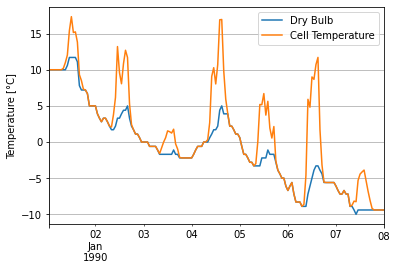

In [5]:
df_tmy['DryBulb'].head(24*7).plot()
cell_temperature.head(24*7).plot()
plt.grid()
plt.legend(['Dry Bulb', 'Cell Temperature'])
# note Python 3 can use unicode characters like the degrees symbol
plt.ylabel('Temperature [°C]');

Wind speed also has an effect, but it’s harder to see in a time series plot like this. To make it clearer, let’s make a scatter plot:

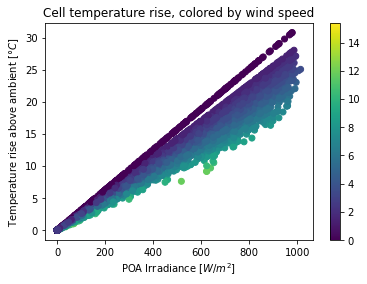

In [6]:
temperature_difference = cell_temperature - df_tmy['DryBulb']
plt.scatter(tracker_poa, temperature_difference, c=df_tmy['Wspd'])
plt.colorbar()
# note you can use LaTeX math in matplotlib labels
# compare \degree" with the unicode symbol above
plt.ylabel('Temperature rise above ambient [$\degree C$]')
plt.xlabel('POA Irradiance [$W/m^2$]');
plt.title('Cell temperature rise, colored by wind speed');

The main trend is a bigger temperature difference as incident irradiance increases. However, this plot shows that higher wind speed reduces the effect – faster wind means more convective cooling, so a lower cell temperature than it would be in calm air.

Note: the gap at the upper edge of the trend is an artifact of the low resolution of wind speed values in this TMY dataset; there are no values between 0 and 0.3 m/s.

## Prueba sorpresa

Ahora es tu turno. Hay otro archivo TMY3 más antiguo en la carpeta de datos pvlib: "703165TY.csv".

Crea una ruta al archivo TMY3: "703165TY.csv" utilizando DATA_DIR y el operador /.

Carga las series de tiempo y los metadatos del archivo

¿Cuál es el nombre de la estación en los metadatos?

Suponiendo un módulo de polímero de vidrio en un tejado horizontalmente plano, utilice el SAPM para calcular la temperatura de la célula

¿Cuál es el plano de irradiancia del array que incide sobre el módulo horizontal de la cubierta?

¿Qué parámetros deben utilizarse para un módulo sobre tejado?


Compara en el mismo gráfico los datos de temperatura ambiente de la primera semana con las temperaturas calculadas para las células.

1.-Crea una ruta al archivo TMY3: "703165TY.csv" utilizando DATA_DIR y el operador /.

Carga las series de tiempo y los metadatos del archivo

In [7]:
DATA_DIR = pathlib.Path(pvlib.__file__).parent / 'data'
df_tmy, metadata = pvlib.iotools.read_tmy3(DATA_DIR / '703165TY.csv', coerce_year=1990)

location = pvlib.location.Location(
    latitude=metadata['latitude'], longitude=metadata['longitude'])

times = df_tmy.index - pd.Timedelta('30min')
solar_position = location.get_solarposition(times)

solar_position.index += pd.Timedelta('30min')

tracker_data = pvlib.tracking.singleaxis(
    solar_position['apparent_zenith'], solar_position['azimuth'], axis_azimuth=180)
tilt = tracker_data['surface_tilt'].fillna(0)
azimuth = tracker_data['surface_azimuth'].fillna(0)

df_poa_tracker = pvlib.irradiance.get_total_irradiance(
    surface_tilt=tilt,
    surface_azimuth=azimuth,
    dni=df_tmy['DNI'],
    ghi=df_tmy['GHI'],
    dhi=df_tmy['DHI'],
    solar_zenith=solar_position['apparent_zenith'],
    solar_azimuth=solar_position['azimuth'])
tracker_poa = df_poa_tracker['poa_global']

2.-¿Cuál es el nombre de la estación en los metadatos?

In [8]:
DATA_DIR = pathlib.Path(pvlib.__file__).parent / 'data'
df_tmy, meta_dict = pvlib.iotools.read_tmy3(DATA_DIR / '703165TY.csv', coerce_year=1990)
meta_dict  # display the dictionary of metadata

{'USAF': 703165,
 'Name': '"SAND POINT"',
 'State': 'AK',
 'TZ': -9.0,
 'latitude': 55.317,
 'longitude': -160.517,
 'altitude': 7.0}

3.-Suponiendo un módulo de polímero de vidrio en un tejado horizontalmente plano, utilice el SAPM para calcular la temperatura de la célula.

3.1.-¿Cuál es el plano de irradiancia del array que incide sobre el módulo horizontal de la cubierta?

3.2.-¿Qué parámetros deben utilizarse para un módulo sobre tejado?

In [9]:
all_parameters = pvlib.temperature.TEMPERATURE_MODEL_PARAMETERS['sapm']
list(all_parameters.keys())

['open_rack_glass_glass',
 'close_mount_glass_glass',
 'open_rack_glass_polymer',
 'insulated_back_glass_polymer']

In [10]:
parameters = all_parameters['open_rack_glass_polymer']
# note the "splat" operator "**" which expands the dictionary "parameters"
# into a comma separated list of keyword arguments
cell_temperature = pvlib.temperature.sapm_cell(
    tracker_poa, df_tmy['DryBulb'], df_tmy['Wspd'], **parameters)

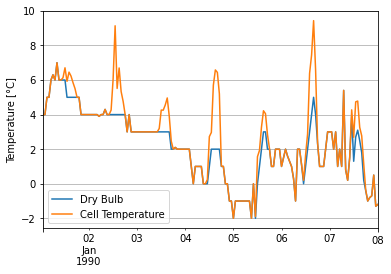

In [11]:
df_tmy['DryBulb'].head(24*7).plot()
cell_temperature.head(24*7).plot()
plt.grid()
plt.legend(['Dry Bulb', 'Cell Temperature'])
# note Python 3 can use unicode characters like the degrees symbol
plt.ylabel('Temperature [°C]');

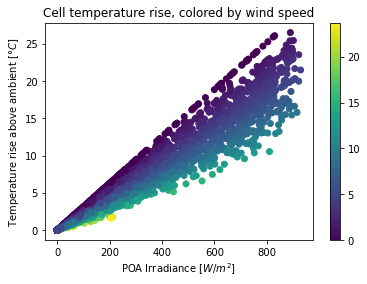

In [12]:
temperature_difference = cell_temperature - df_tmy['DryBulb']
plt.scatter(tracker_poa, temperature_difference, c=df_tmy['Wspd'])
plt.colorbar()
# note you can use LaTeX math in matplotlib labels
# compare \degree" with the unicode symbol above
plt.ylabel('Temperature rise above ambient [$\degree C$]')
plt.xlabel('POA Irradiance [$W/m^2$]');
plt.title('Cell temperature rise, colored by wind speed');